In [1]:
import pandas as pd
import numpy as np

import os
import random

from numpy.random import seed

from keras.layers.experimental import preprocessing
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# For reproducible results
seed_value = 1
os.environ['PYTHONHASHSEED'] = str(seed_value)

random.seed(seed_value)

np.random.seed(seed_value)

tf.random.set_seed(seed_value)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [3]:
OUTPUT_PATH = './Data/output/'

### Import dataset

In [4]:
dataset_raw = pd.read_csv(OUTPUT_PATH + 'CleanData_Population_Schools_SDGs.csv')
dataset_raw['No_of_Schools'] = dataset_raw['SCH_TYPE_PRIVATE'] + dataset_raw['SCH_TYPE_PUBLIC'] + dataset_raw['SCH_TYPE_SUC']
len(dataset_raw)

2482

In [5]:
dataset = dataset_raw.dropna().reset_index()
len(dataset)

1756

### Preprocess data

In [6]:
SDG = dataset.iloc[:,85:]
SDG['PSGC_BRGY'] = dataset['PSGC_BRGY']

#### 1. Elementary

In [7]:
data_elem = SDG.copy()
data_elem['NUM_SCHOOLS'] = dataset['SCH_CAT_CES'] + dataset['SCH_CAT_ES'] + dataset['SCH_CAT_PS'] + dataset['SCH_CAT_PES']
data_elem['ELEM_POPN'] = dataset['both_age_6_to_12']
len(data_elem)

1756

In [8]:
zero_schools_elem = data_elem[data_elem['NUM_SCHOOLS'] == 0]
data_elem = data_elem[data_elem['NUM_SCHOOLS'] != 0]
data_elem = data_elem.drop(['PSGC_BRGY'], axis=1)
len(data_elem)

1703

#### 2. High School

In [9]:
data_hs = SDG.copy()
data_hs['NUM_SCHOOLS'] = dataset['SCH_CAT_JHS'] + dataset['SCH_CAT_SHS'] + dataset['SCH_CAT_PJHS'] + dataset['SCH_CAT_PSHS']
data_hs['HS_POPN'] = dataset['both_age_13_to_16']
len(data_hs)

1756

In [10]:
zero_schools_hs = data_hs[data_hs['NUM_SCHOOLS'] == 0]
data_hs = data_hs[data_hs['NUM_SCHOOLS'] != 0]
data_hs = data_hs.drop(['PSGC_BRGY'], axis=1)
len(data_hs)

366

### Modelling

In [11]:
def base_model(normalizer):
    np.random.seed(1)
    model = Sequential()
    model.add(normalizer)
    model.add(Dense(4, input_dim=1, activation='relu'))
    model.add(Dense(4, activation='relu'))
    model.add(Dense(1, activation='linear'))

    model.compile(loss='mse', optimizer='adam')

    return model

In [12]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error')
    plt.legend()
    plt.grid(True)

In [13]:
def model_data(data, feature='all'):
    # Paramaters: data = data to be used
    #             features =  all if dimension of X_train > 1. If X_train dimension == 1, specify column name
    training_data, testing_data = train_test_split(data, test_size=0.2, random_state=42)
    X_train = training_data.drop(['NUM_SCHOOLS'], axis=1)
    y_train = training_data['NUM_SCHOOLS']

    X_test = testing_data.drop(['NUM_SCHOOLS'], axis=1)
    y_test = testing_data['NUM_SCHOOLS']
    
    if feature == 'all':
        normalizer = preprocessing.Normalization()
        normalizer.adapt(np.array(X_train))
    else:
        X_train = X_train[[feature]]
        X_test = X_test[[feature]]
        normalizer = preprocessing.Normalization(input_shape=[1,])
        normalizer.adapt(np.array(X_train[feature]))
    
    model = base_model(normalizer)
    EPOCHS = 200
    BATCH_SIZE = 10


    callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

    history = model.fit(X_train, 
                        y_train, 
                        epochs=EPOCHS, 
                        batch_size=BATCH_SIZE,
                        validation_split=0.2,
                        callbacks=callback,
                        verbose=False)
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    hist.tail()
    
    plot_loss(history)
    
    y_pred = model.predict(X_test)
    y_pred_round = np.round(y_pred)
    acc = accuracy_score(y_test, y_pred_round)
    
    print('Model accuracy:', acc)
    
    return model

In [14]:
def predict(model, X_predict):
    y_pred_null = model.predict(X_predict)
    return np.round(y_pred_null)

In [15]:
dataset_null = dataset_raw[dataset_raw.isnull().any(axis=1)]
len(dataset_null)

726

In [16]:
def save_prediction(model, level, feature='all'):
    X_predict_1 = dataset_null.copy()
    X_predict_1 = X_predict_1.iloc[:, 84:]
    if level == 'elem':
        X_predict_1['ELEM_POPN'] = dataset_null['both_age_6_to_12']
        _zero_schools = zero_schools_elem.copy()
    elif level == 'hs':
        X_predict_1['HS_POPN'] = dataset_null['both_age_13_to_16']
        _zero_schools = zero_schools_hs.copy()
        
    X_predict_2 = _zero_schools.drop(['NUM_SCHOOLS','PSGC_BRGY'], axis=1)
        
    if feature == 'all':
        X_predict_1['Pred_school_num'] = predict(model, X_predict_1)
        X_predict_2['Pred_school_num'] = predict(model, X_predict_2)
    else:
        X_predict_1 = X_predict_1[[feature]]
        X_predict_2 = X_predict_2[[feature]]
        X_predict_1['Pred_school_num'] = predict(model, X_predict_1[feature])
        X_predict_2['Pred_school_num'] = predict(model, X_predict_2[feature])
        
    X_predict_1['PSGC_BRGY'] = dataset_null['PSGC_BRGY']
    X_predict_2['PSGC_BRGY'] = _zero_schools['PSGC_BRGY']
    
    predicted_df = pd.concat([X_predict_1, X_predict_2])
    
    print('Number of barangays predicted:', len(predicted_df))
    return predicted_df

Model accuracy: 0.782991202346041
Number of barangays predicted: 779


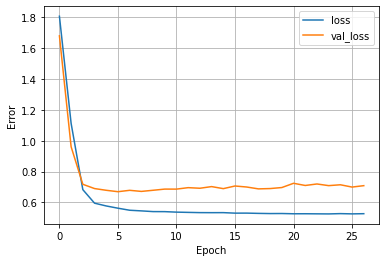

In [17]:
elem_model = model_data(data_elem, 'ELEM_POPN')
elem_df_pop = save_prediction(elem_model, 'elem', 'ELEM_POPN')
# elem_df_pop.to_csv(OUTPUT_PATH + 'Model_NN_Output_Elem_pop.csv', index=False)

Model accuracy: 0.7536656891495601
Number of barangays predicted: 779


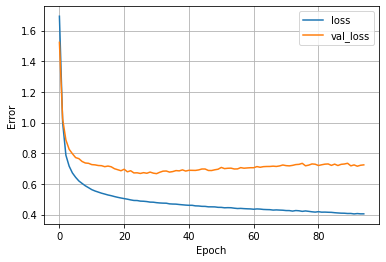

In [18]:
elem_model = model_data(data_elem, 'all')
elem_df = save_prediction(elem_model, 'elem', 'all')
# elem_df.to_csv(OUTPUT_PATH + 'Model_NN_Output_Elem.csv', index=False)

Model accuracy: 0.8378378378378378
Number of barangays predicted: 2116


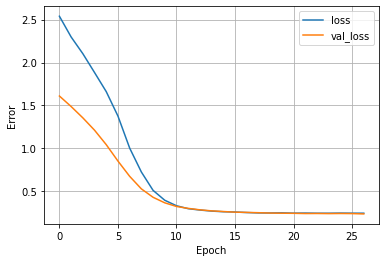

In [19]:
hs_model = model_data(data_hs, 'HS_POPN')
hs_df_pop = save_prediction(hs_model, 'hs', 'HS_POPN')
# hs_df_pop.to_csv(OUTPUT_PATH + 'Model_NN_Output_HS_pop.csv', index=False)

Model accuracy: 0.7702702702702703
Number of barangays predicted: 2116


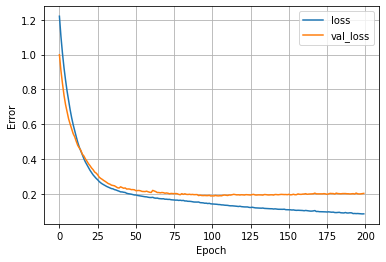

In [20]:
hs_model = model_data(data_hs, 'all')
hs_df = save_prediction(hs_model, 'hs', 'all')
# hs_df.to_csv(OUTPUT_PATH + 'Model_NN_Output_HS.csv', index=False)